In [1]:
import distmesh as dm
import numpy as np
import math
import scipy
from scipy.sparse import csr_matrix,lil_matrix
from scipy.sparse import diags
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size': 10})

pi = math.pi

In [2]:
def V(v):
    x = v[0]
    y = v[1]
    return np.cos(2*np.pi*x) + (0.5*np.sin(np.pi*x))**2

def M_term(v):
    x = v[0]
    y = v[1]
    M = np.zeros((2,2))
    M[0,0] = 1 + 0.5*np.cos(np.pi*x)
    M[1,1] = 1 + 0.5*np.cos(np.pi*x)
    M[0,1] = 0.5*np.sin(np.pi*x)
    M[1,0] = 0.5*np.sin(np.pi*x)
    return M

In [3]:
def stima3(verts):
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    
#     term1 = (-1) * np.exp(-1*V(verts[0])) * M_term(verts[0])
#     term2 = (-1) * np.exp(-1*V(verts[1])) * M_term(verts[1])
#     term3 = (-1) * np.exp(-1*V(verts[2])) * M_term(verts[2])
#     Aux[1:3,0] = term1 @ verts[0]
#     Aux[1:3,1] = term2 @ verts[1]
#     Aux[1:3,2] = term3 @ verts[2]

    vmid = np.reshape(np.sum(v,axis=0)/3,(2,1))

    rhs = np.zeros((3,2))
    rhs[1,0] = 1
    rhs[2,1] = 1
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    M = 0.5*np.linalg.det(Aux)*np.matmul(np.matmul(G,M_term(vmid)),np.transpose(G))
#     M = 0.5*np.linalg.det(Aux)*np.matmul(G,np.transpose(G))
    return M

# from distmesh without tri
def triarea(pts):
    # calculates areas of mesh triangle
    # p = [x_vec,y_vec]
    term1 = (-1) * np.exp(-1*V(pts[0])) * M_term(pts[0])
    term2 = (-1) * np.exp(-1*V(pts[1])) * M_term(pts[1])
    term3 = (-1) * np.exp(-1*V(pts[2])) * M_term(pts[2])
    pts[0] = term1 @ pts[0]
    pts[1] = term2 @ pts[1]
    pts[2] = term3 @ pts[2]
    
    d12 = pts[1,:]-pts[0,:]
    d13 = pts[2,:]-pts[0,:]
    return d12[0]*d13[1]-d12[1]*d13[0]

# Function for mass matrix.
def massma3(verts):
    Aux = np.ones((3,3))
    np.fill_diagonal(Aux,2)
    return triarea(verts)/24*Aux

# load vector
def load(verts):
    return triarea(verts)/6

count =  200 displacement =  0.008250681006895149
count =  400 displacement =  0.004394703555597731
count =  600 displacement =  0.007355846556369482
count =  800 displacement =  0.006986608589320369
count =  1000 displacement =  0.004890523954694812
count =  1200 displacement =  0.0074643921730652985
count =  1400 displacement =  0.006652353387784167
count =  1600 displacement =  0.004816928223482027
count =  1800 displacement =  0.007383908283203486
count =  2000 displacement =  0.006395464721750408
count =  2200 displacement =  0.00480518587249141
count =  2400 displacement =  0.00738640717669944
count =  2600 displacement =  0.006270484661191256
count =  2800 displacement =  0.00481340958124018
count =  3000 displacement =  0.007404015757170581
count =  3200 displacement =  0.006209448862898365
count =  3400 displacement =  0.0048215142165053335
count =  3600 displacement =  0.007416994947940011
count =  3800 displacement =  0.006178653500092081
count =  4000 displacement =  0.0048

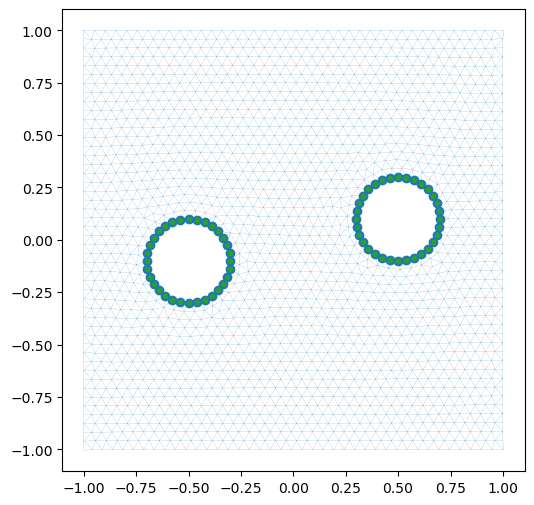

In [4]:
# construct total region
d_annulus = lambda p: dm.ddiff(dm.drectangle(p, -1, 1, -1, 1), dm.dunion(dm.dcircle(p,-0.5,-0.1*np.sin(0.5*pi),0.2),dm.dcircle(p,0.5,0.1*np.sin(0.5*pi),0.2)))

plt.figure(figsize=(6, 6))

# fixed points
h0 = 2*pi/32
n = int(np.round(2*pi/h0))
bdry_A = [[0.2*math.cos(2*pi*i/n)-0.5, 0.2*math.sin(2*pi*i/n)-0.1*np.sin(0.5*pi)] for i in range(n)]
bdry_B = [[0.2*math.cos(2*pi*i/n)+0.5, 0.2*math.sin(2*pi*i/n)+0.1*np.sin(0.5*pi)] for i in range(n)]
pfix = bdry_A.copy()
pfix.extend(bdry_B)
pfix = np.array(pfix)
plt.scatter(pfix[:,0], pfix[:,1])
# solve system
# [pts,tri] = dm.distmesh2D(d_annulus, dm.huniform, h0/8, [-1, 1, -1, 1], pfix)
[pts,tri] = dm.distmesh2D(d_annulus, dm.huniform, h0/4, [-1, 1, -1, 1], pfix)
Npts,Ntri = len(pts),len(tri)

# ax.set_aspect(1)
plt.plot([p[0] for p in pfix], [p[1] for p in pfix],'.')

In [24]:
print(Npts)

1909


In [5]:
# indices for points on D0, D1, Neuman Boundary
IDir = [i for i in range(Npts) if pts[i] in pfix]
I_bdry_B = [i for i in range(Npts) if pts[i] in np.array(bdry_B)]

print(len(IDir))
print(len(I_bdry_B))
I_bdry_B = np.delete(I_bdry_B, 0)
I_bdry_B = np.delete(I_bdry_B, 0)
print(len(I_bdry_B))

# indices for free points
Ifree = [i for i in range(len(pts)) if i not in IDir]
print(Npts)
print(Ntri)
print(len(Ifree))
Ifreegrid = np.ix_(Ifree,Ifree)

64
34
32
1909
3582
1845


In [6]:
# initialize matrices
A = scipy.sparse.csr_matrix((Npts,Npts), dtype = float).toarray()
# B = lil_matrix((Npts,Npts), dtype = float)
b = np.zeros((Npts,1))
u = np.zeros((Npts,1)) # the solution
u[I_bdry_B] = 1

for j in range(Ntri):
    v = pts[tri[j,:],:] # vertices of mesh triangle
    vmid = np.reshape(np.sum(v,axis=0)/3,(2,1)) # midpoint of mesh triangle
    ind = tri[j,:]
    indt = np.array(ind)[:,None]
    A[indt,ind] += stima3(v) * (-1) * np.exp(-1*V(vmid))

# load vector
b = b - np.matmul(A,u)
             
# solve for committor
free_nodes_t = np.array(Ifree)[:,None]
u[Ifree] = scipy.linalg.solve(A[free_nodes_t,Ifree],b[Ifree])
u = np.reshape(u,(Npts,))

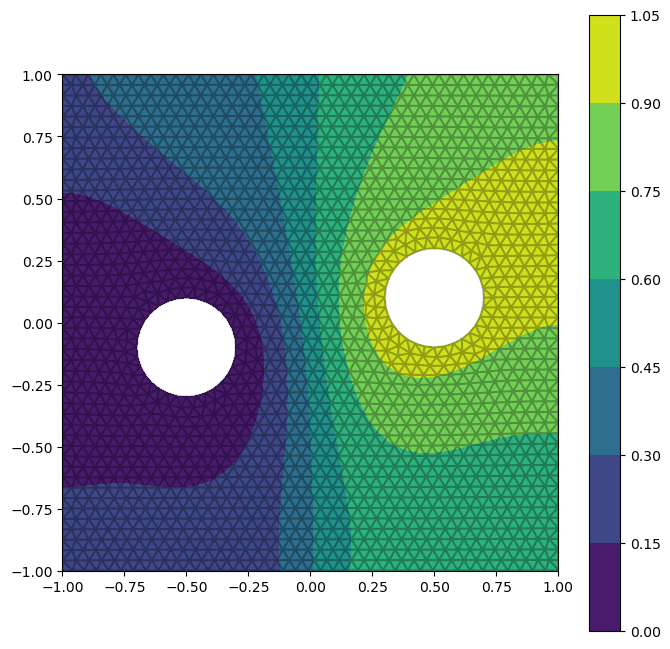

In [7]:
# visualization
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,8))
plt.tricontourf(pts[:,0], pts[:,1],tri,u)
plt.colorbar()
ax.set_aspect('equal')
ax.set(xlim=(-1,1), ylim=(-1,1)) 

plt.triplot(pts[:,0],pts[:,1],tri, color='black', alpha=0.3)
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 10})

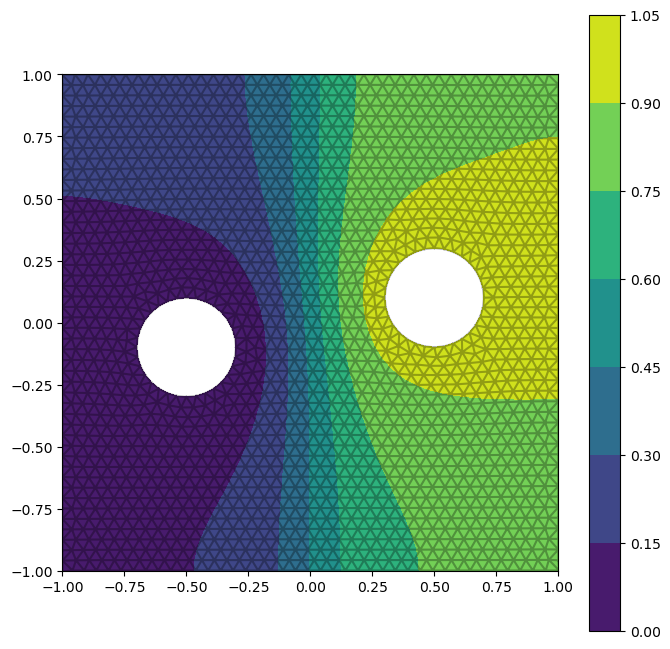

In [28]:
# visualization
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize = (8,8))
plt.tricontourf(pts[:,0], pts[:,1],tri,u)
plt.colorbar()
ax.set_aspect('equal')
ax.set(xlim=(-1,1), ylim=(-1,1)) 

plt.triplot(pts[:,0],pts[:,1],tri, color='black', alpha=0.3)
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 10})